# Time Series Analysis and Forecasting
## ETH-USD Price Forecasting using Exponential Smoothing

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and prepare the data
df = pd.read_csv("eth-usd-max.csv", parse_dates=["snapped_at"])
df = df.set_index("snapped_at").sort_index()

# Ensure daily frequency and interpolate missing days
price = df["price"].asfreq("D")
price = price.interpolate(method='linear')

print(f"Data range: {price.index[0]} to {price.index[-1]}")
print(f"Total observations: {len(price)}")
print(f"Missing values after interpolation: {price.isna().sum()}")
price.head(10)

Data range: 2015-08-07 00:00:00+00:00 to 2025-11-17 00:00:00+00:00
Total observations: 3756
Missing values after interpolation: 0


snapped_at
2015-08-07 00:00:00+00:00    2.831620
2015-08-08 00:00:00+00:00    1.330750
2015-08-09 00:00:00+00:00    1.009168
2015-08-10 00:00:00+00:00    0.687586
2015-08-11 00:00:00+00:00    1.067379
2015-08-12 00:00:00+00:00    1.256613
2015-08-13 00:00:00+00:00    1.825395
2015-08-14 00:00:00+00:00    1.825975
2015-08-15 00:00:00+00:00    1.670950
2015-08-16 00:00:00+00:00    1.476607
Freq: D, Name: price, dtype: float64

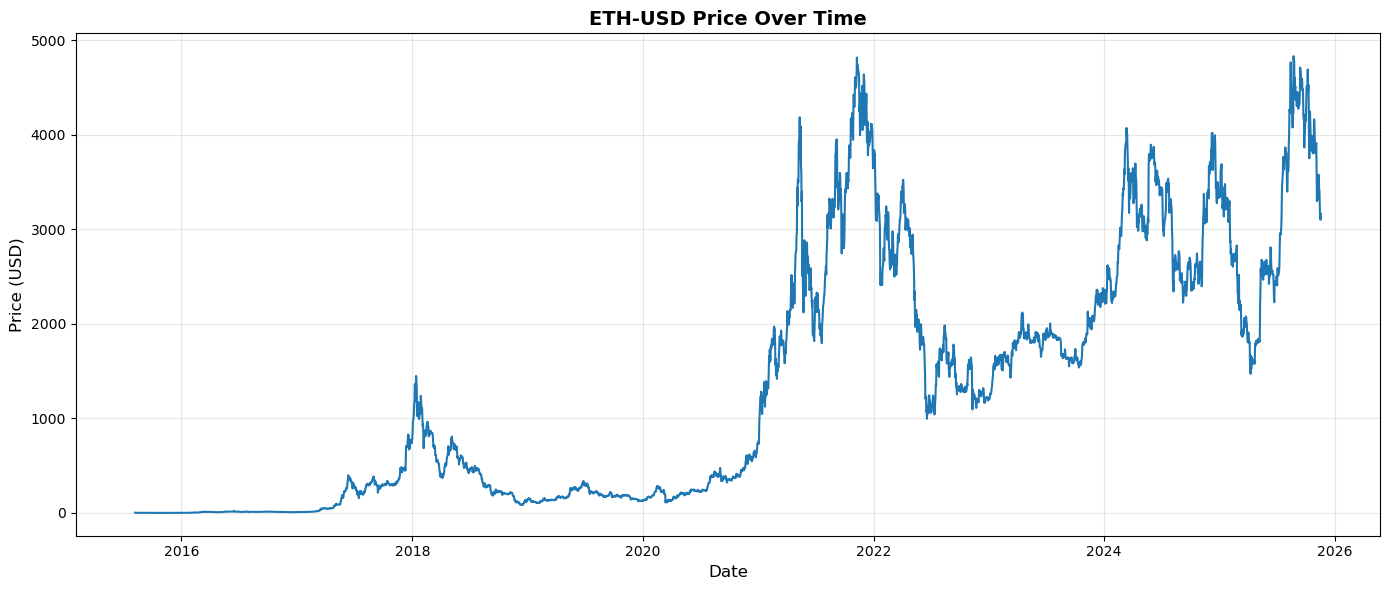

In [3]:
# Visualize the time series
plt.figure(figsize=(14, 6))
plt.plot(price, linewidth=1.5)
plt.title('ETH-USD Price Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

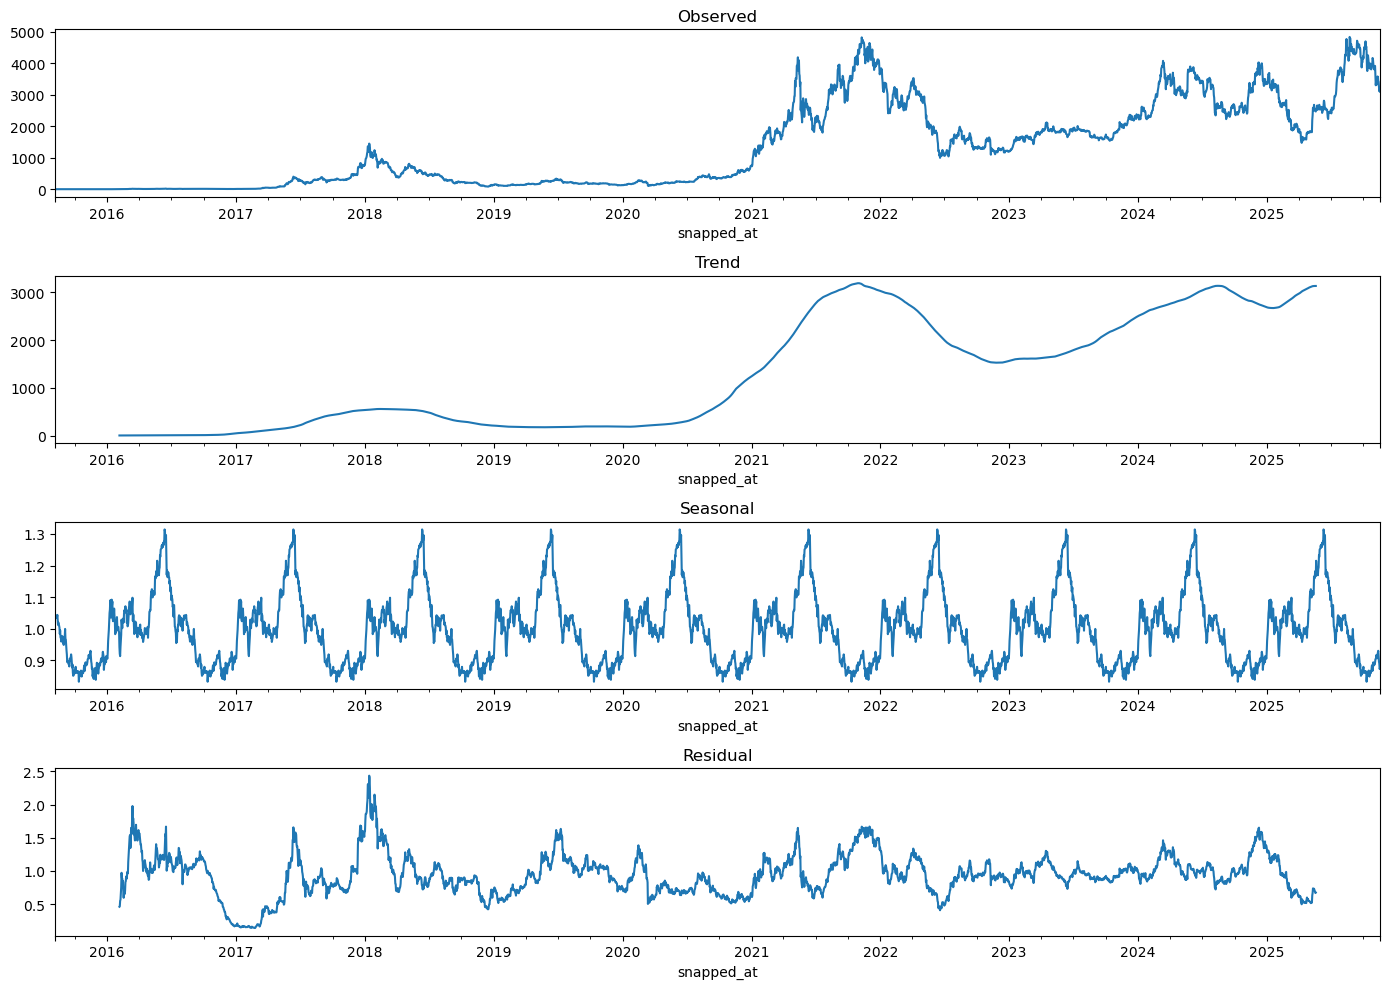

In [4]:
# Seasonal decomposition (if there's enough data)
if len(price) >= 730:  # At least 2 years of data
    decomposition = seasonal_decompose(price, model='multiplicative', period=365)
    
    fig, axes = plt.subplots(4, 1, figsize=(14, 10))
    decomposition.observed.plot(ax=axes[0], title='Observed')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough data for seasonal decomposition (need at least 730 days, have {len(price)})")

In [5]:
# Split data into train and test sets (80-20 split)
train_size = int(len(price) * 0.8)
train = price[:train_size]
test = price[train_size:]

print(f"Training set: {len(train)} observations ({train.index[0]} to {train.index[-1]})")
print(f"Test set: {len(test)} observations ({test.index[0]} to {test.index[-1]})")

Training set: 3004 observations (2015-08-07 00:00:00+00:00 to 2023-10-27 00:00:00+00:00)
Test set: 752 observations (2023-10-28 00:00:00+00:00 to 2025-11-17 00:00:00+00:00)


In [6]:
# Simple Exponential Smoothing
print("\n=== Simple Exponential Smoothing ===")
model_ses = ExponentialSmoothing(train, trend=None, seasonal=None)
fitted_ses = model_ses.fit()
forecast_ses = fitted_ses.forecast(steps=len(test))

# Calculate metrics
mse_ses = mean_squared_error(test, forecast_ses)
rmse_ses = np.sqrt(mse_ses)
mae_ses = mean_absolute_error(test, forecast_ses)
mape_ses = np.mean(np.abs((test - forecast_ses) / test)) * 100

print(f"RMSE: ${rmse_ses:.2f}")
print(f"MAE: ${mae_ses:.2f}")
print(f"MAPE: {mape_ses:.2f}%")


=== Simple Exponential Smoothing ===
RMSE: $1393.50
MAE: $1182.57
MAPE: 35.84%


In [7]:
# Holt's Linear Trend (Double Exponential Smoothing)
print("\n=== Holt's Linear Trend ===")
model_holt = ExponentialSmoothing(train, trend='add', seasonal=None)
fitted_holt = model_holt.fit()
forecast_holt = fitted_holt.forecast(steps=len(test))

# Calculate metrics
mse_holt = mean_squared_error(test, forecast_holt)
rmse_holt = np.sqrt(mse_holt)
mae_holt = mean_absolute_error(test, forecast_holt)
mape_holt = np.mean(np.abs((test - forecast_holt) / test)) * 100

print(f"RMSE: ${rmse_holt:.2f}")
print(f"MAE: ${mae_holt:.2f}")
print(f"MAPE: {mape_holt:.2f}%")


=== Holt's Linear Trend ===
RMSE: $1188.48
MAE: $998.08
MAPE: 30.40%


In [8]:
# Holt-Winters (Triple Exponential Smoothing) - only if enough data
if len(train) >= 730:  # Need at least 2 years for seasonal model
    print("\n=== Holt-Winters (Seasonal) ===")
    try:
        model_hw = ExponentialSmoothing(
            train, 
            trend='add', 
            seasonal='add', 
            seasonal_periods=365
        )
        fitted_hw = model_hw.fit()
        forecast_hw = fitted_hw.forecast(steps=len(test))
        
        # Calculate metrics
        mse_hw = mean_squared_error(test, forecast_hw)
        rmse_hw = np.sqrt(mse_hw)
        mae_hw = mean_absolute_error(test, forecast_hw)
        mape_hw = np.mean(np.abs((test - forecast_hw) / test)) * 100
        
        print(f"RMSE: ${rmse_hw:.2f}")
        print(f"MAE: ${mae_hw:.2f}")
        print(f"MAPE: {mape_hw:.2f}%")
    except Exception as e:
        print(f"Could not fit Holt-Winters model: {e}")
        forecast_hw = None
else:
    print(f"\nSkipping Holt-Winters: need at least 730 days of training data, have {len(train)}")
    forecast_hw = None


=== Holt-Winters (Seasonal) ===
RMSE: $1278.31
MAE: $1066.11
MAPE: 32.14%


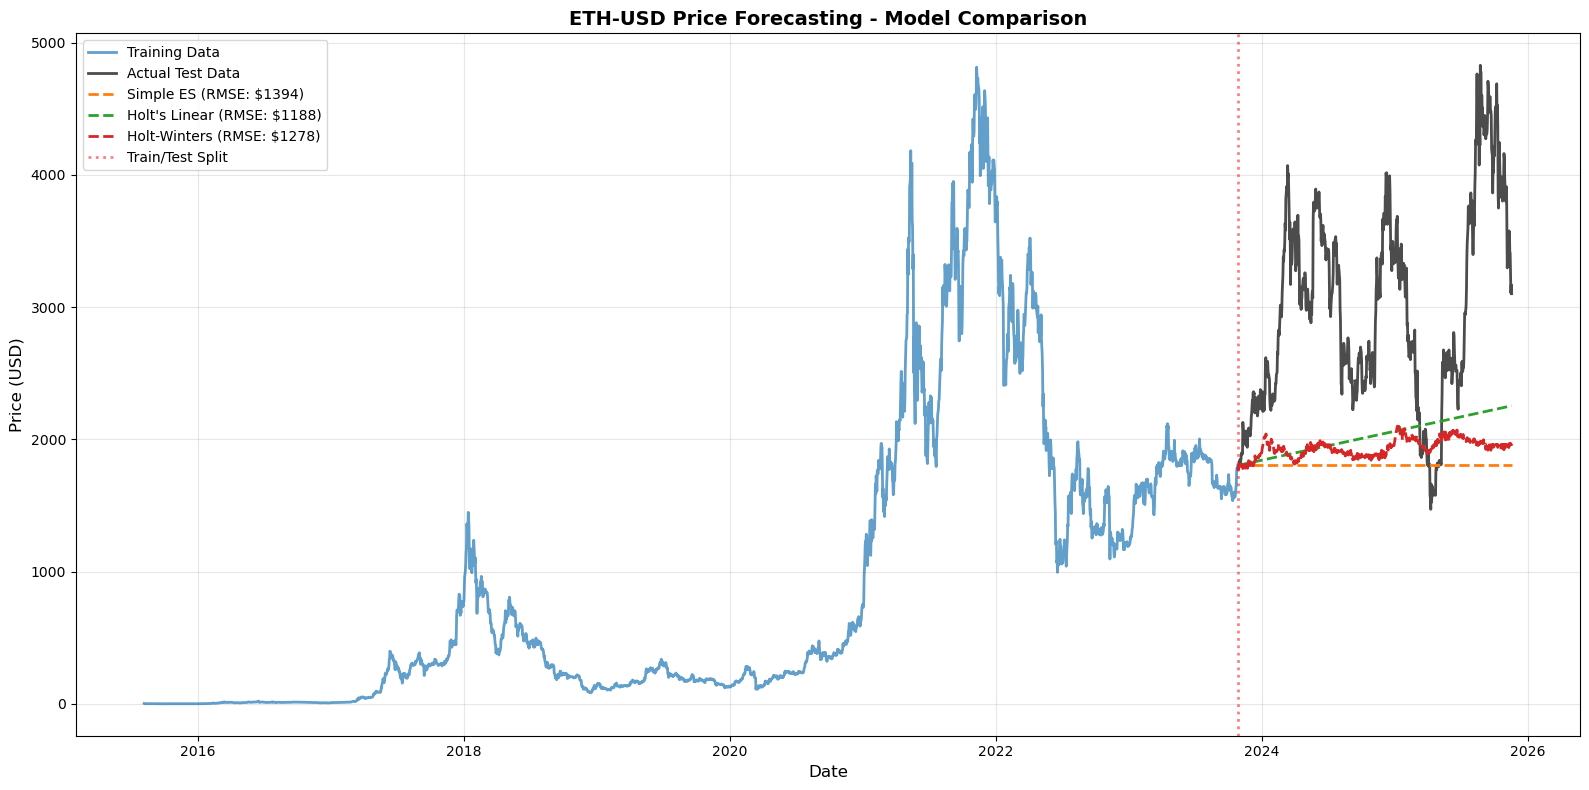

In [9]:
# Compare all models
plt.figure(figsize=(16, 8))
plt.plot(train.index, train, label='Training Data', linewidth=2, alpha=0.7)
plt.plot(test.index, test, label='Actual Test Data', linewidth=2, color='black', alpha=0.7)
plt.plot(test.index, forecast_ses, label=f'Simple ES (RMSE: ${rmse_ses:.0f})', linewidth=2, linestyle='--')
plt.plot(test.index, forecast_holt, label=f"Holt's Linear (RMSE: ${rmse_holt:.0f})", linewidth=2, linestyle='--')

if forecast_hw is not None:
    plt.plot(test.index, forecast_hw, label=f'Holt-Winters (RMSE: ${rmse_hw:.0f})', linewidth=2, linestyle='--')

plt.axvline(x=train.index[-1], color='red', linestyle=':', linewidth=2, alpha=0.5, label='Train/Test Split')
plt.title('ETH-USD Price Forecasting - Model Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Make future predictions (30 days ahead)
forecast_days = 90

# Retrain on full dataset for future predictions
print(f"\n=== Forecasting {forecast_days} days into the future ===")

# Use the best performing model (usually Holt's Linear for crypto)
final_model = ExponentialSmoothing(price, trend='add', seasonal=None)
final_fitted = final_model.fit()
future_forecast = final_fitted.forecast(steps=forecast_days)

# Create future dates
last_date = price.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_days, freq='D')
future_forecast.index = future_dates

print(f"\nForecast from {future_dates[0].date()} to {future_dates[-1].date()}:")
print(future_forecast.head(10))


=== Forecasting 90 days into the future ===

Forecast from 2025-11-18 to 2026-02-15:
2025-11-18 00:00:00+00:00    3105.196835
2025-11-19 00:00:00+00:00    3106.022960
2025-11-20 00:00:00+00:00    3106.849085
2025-11-21 00:00:00+00:00    3107.675210
2025-11-22 00:00:00+00:00    3108.501335
2025-11-23 00:00:00+00:00    3109.327460
2025-11-24 00:00:00+00:00    3110.153585
2025-11-25 00:00:00+00:00    3110.979710
2025-11-26 00:00:00+00:00    3111.805835
2025-11-27 00:00:00+00:00    3112.631960
Freq: D, dtype: float64


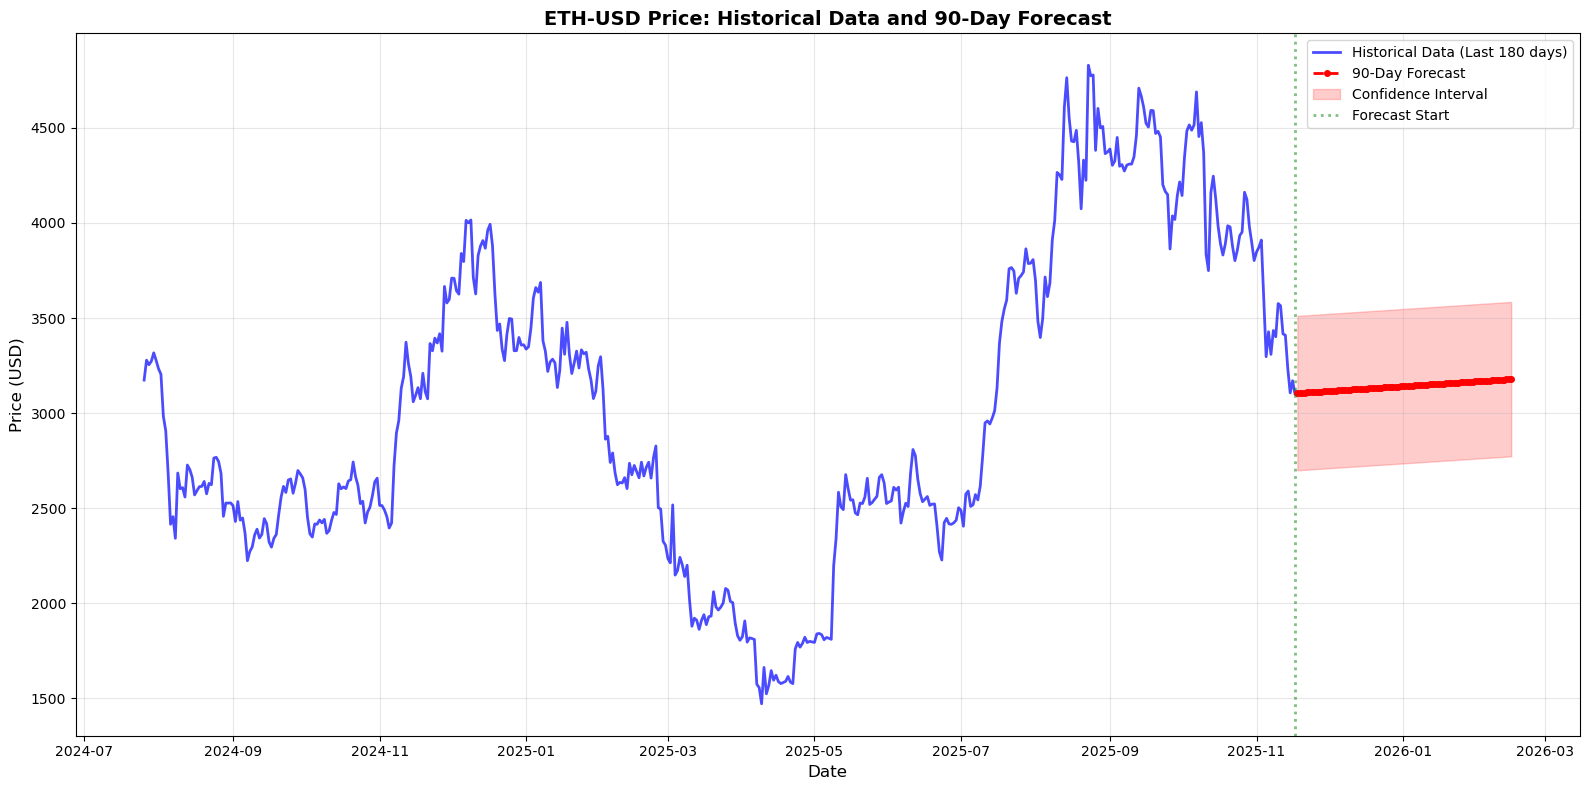


Current Price (last known): $3101.69
Forecasted Price (90 days): $3178.72
Expected Change: 2.48%


In [15]:
# Plot historical data with future forecast
plt.figure(figsize=(16, 8))

# Plot last 180 days of historical data for context
recent_data = price[-480:]
plt.plot(recent_data.index, recent_data, label='Historical Data (Last 180 days)', 
         linewidth=2, color='blue', alpha=0.7)
plt.plot(future_forecast.index, future_forecast, label=f'{forecast_days}-Day Forecast', 
         linewidth=2, color='red', linestyle='--', marker='o', markersize=4)

# Add confidence interval (rough estimate)
std_error = np.std(price[-480:]) * 0.5  # Simplified confidence band
plt.fill_between(future_forecast.index, 
                 future_forecast - std_error, 
                 future_forecast + std_error, 
                 alpha=0.2, color='red', label='Confidence Interval')

plt.axvline(x=price.index[-1], color='green', linestyle=':', linewidth=2, 
            alpha=0.5, label='Forecast Start')
plt.title(f'ETH-USD Price: Historical Data and {forecast_days}-Day Forecast', 
          fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nCurrent Price (last known): ${price.iloc[-1]:.2f}")
print(f"Forecasted Price ({forecast_days} days): ${future_forecast.iloc[-1]:.2f}")
print(f"Expected Change: {((future_forecast.iloc[-1] / price.iloc[-1]) - 1) * 100:.2f}%")

In [12]:
# Export forecast to CSV
forecast_df = pd.DataFrame({
    'date': future_forecast.index,
    'forecasted_price': future_forecast.values,
    'lower_bound': future_forecast.values - std_error,
    'upper_bound': future_forecast.values + std_error
})

forecast_df.to_csv('eth_forecast.csv', index=False)
print("\nForecast exported to 'eth_forecast.csv'")
forecast_df


Forecast exported to 'eth_forecast.csv'


,date,forecasted_price,lower_bound,upper_bound
0,2025-11-18 00:00:00+00:00,3105.196835,2720.077336,3490.316334
1,2025-11-19 00:00:00+00:00,3106.022960,2720.903461,3491.142459
2,2025-11-20 00:00:00+00:00,3106.849085,2721.729586,3491.968584
3,2025-11-21 00:00:00+00:00,3107.675210,2722.555711,3492.794709
4,2025-11-22 00:00:00+00:00,3108.501335,2723.381836,3493.620834
5,2025-11-23 00:00:00+00:00,3109.327460,2724.207961,3494.446959
6,2025-11-24 00:00:00+00:00,3110.153585,2725.034086,3495.273084
7,2025-11-25 00:00:00+00:00,3110.979710,2725.860211,3496.099209
8,2025-11-26 00:00:00+00:00,3111.805835,2726.686336,3496.925334
9,2025-11-27 00:00:00+00:00,3112.631960,2727.512461,3497.751459
